# Essay 3 - Machine Learning approach

This file implements a random forest model to predict recessions based on economic topic counts from Beige Books.

This is intended as a supplement to the primary probit analysis.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load data
df = pd.read_csv("aggregated_predictions_monthly.csv")
df['DATE'] = pd.to_datetime(df['DATE'])

# Define topic columns
topic_columns = ["Employment", "Prices", "Manufacturing", "Construction",
                 "Uncertainty", "Resources", "Transportation", "Outlook",
                 "Labor", "Capital", "Trade", "C"]

# Define target variable (Recession) based on NBER dates
df["Recession"] = 0
df.loc[(df["DATE"] >= "1969-12-01") & (df["DATE"] <= "1970-11-01"), "Recession"] = 1
df.loc[(df["DATE"] >= "1973-11-01") & (df["DATE"] <= "1975-03-01"), "Recession"] = 1
df.loc[(df["DATE"] >= "1980-01-01") & (df["DATE"] <= "1980-06-01"), "Recession"] = 1
df.loc[(df["DATE"] >= "1981-07-01") & (df["DATE"] <= "1982-11-01"), "Recession"] = 1
df.loc[(df["DATE"] >= "1990-07-01") & (df["DATE"] <= "1991-03-01"), "Recession"] = 1
df.loc[(df["DATE"] >= "2001-03-01") & (df["DATE"] <= "2001-11-01"), "Recession"] = 1
df.loc[(df["DATE"] >= "2007-12-01") & (df["DATE"] <= "2009-06-01"), "Recession"] = 1
df.loc[(df["DATE"] >= "2020-02-01") & (df["DATE"] <= "2020-04-01"), "Recession"] = 1

# Create recession lead and lag variables
df["Recession_lead_3"] = df["Recession"].shift(3)
df["Recession_lead_6"] = df["Recession"].shift(6)
df["Recession_lead_8"] = df["Recession"].shift(8)
df["Recession_lead_16"] = df["Recession"].shift(16)
df["Recession_lag_3"] = df["Recession"].shift(-3)
df["Recession_lag_6"] = df["Recession"].shift(-6)

# Drop missing values after shifting
df = df.dropna()

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[topic_columns])


Random Forest Classification Report for Recession:
              precision    recall  f1-score   support

           0       0.91      0.94      0.92        78
           1       0.50      0.42      0.45        12

    accuracy                           0.87        90
   macro avg       0.71      0.68      0.69        90
weighted avg       0.86      0.87      0.86        90



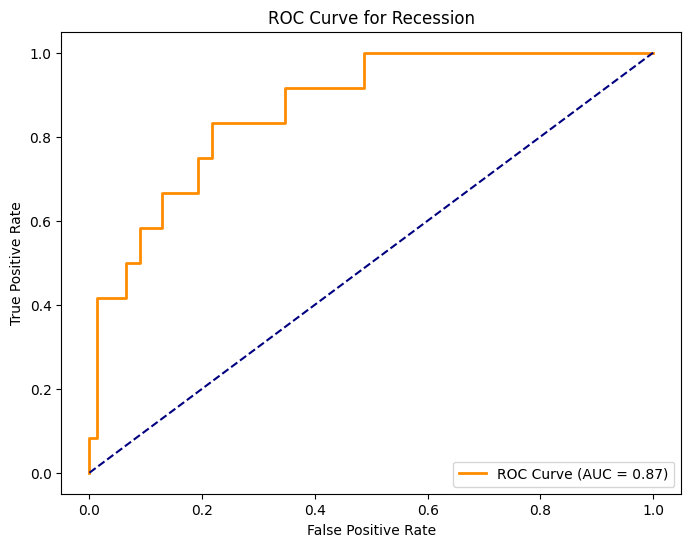

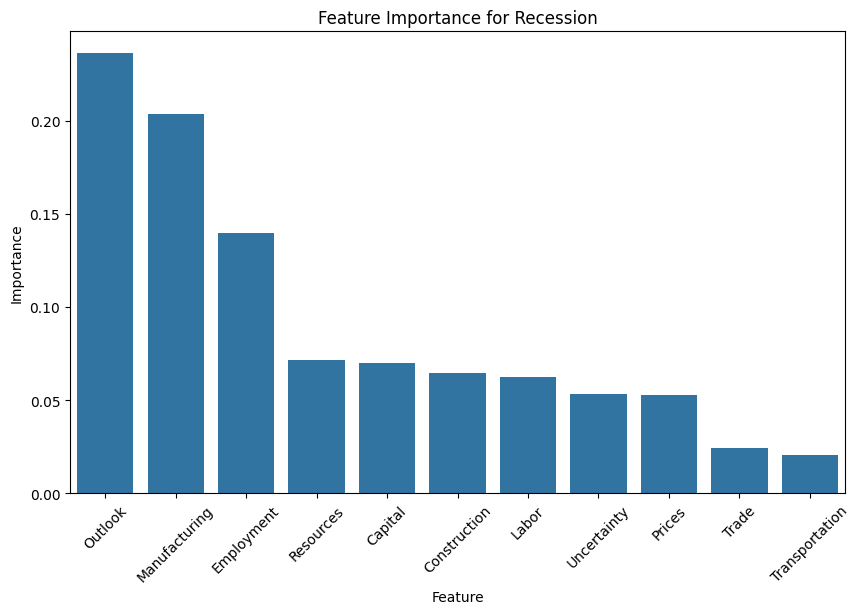


Random Forest Classification Report for Recession_lead_3:
              precision    recall  f1-score   support

         0.0       0.94      0.95      0.94        78
         1.0       0.64      0.58      0.61        12

    accuracy                           0.90        90
   macro avg       0.79      0.77      0.78        90
weighted avg       0.90      0.90      0.90        90



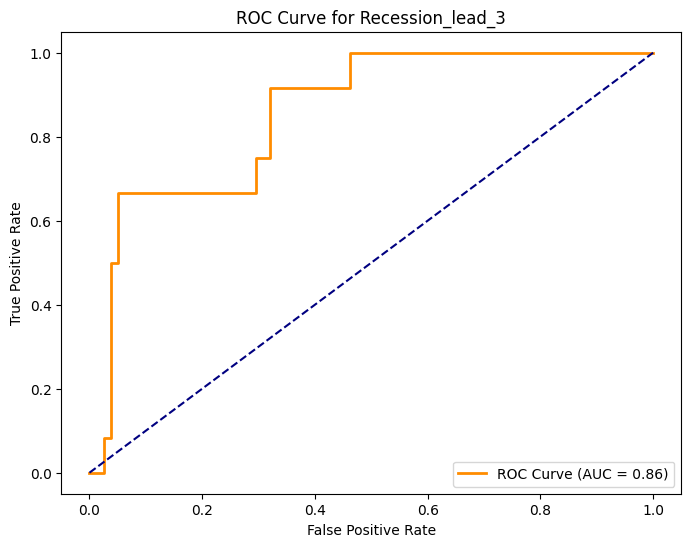

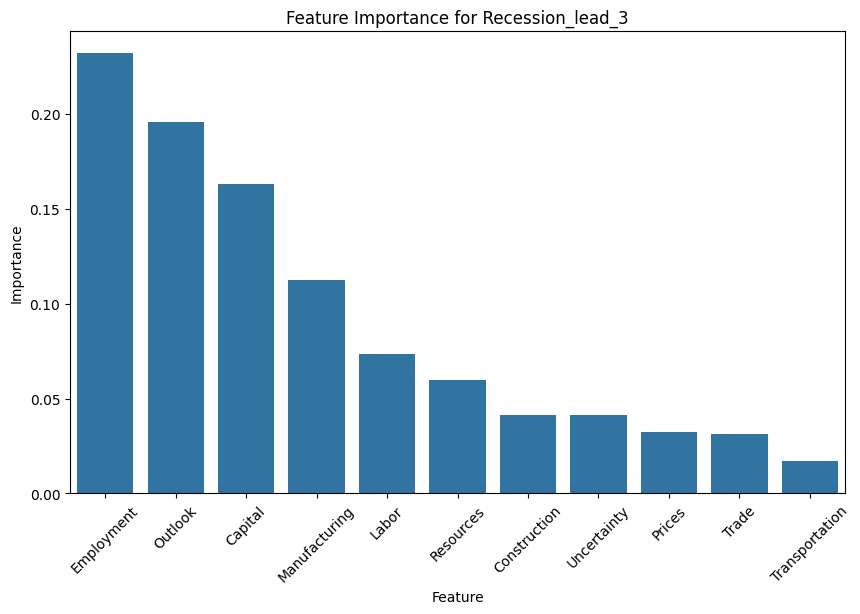


Random Forest Classification Report for Recession_lead_6:
              precision    recall  f1-score   support

         0.0       0.94      0.94      0.94        78
         1.0       0.58      0.58      0.58        12

    accuracy                           0.89        90
   macro avg       0.76      0.76      0.76        90
weighted avg       0.89      0.89      0.89        90



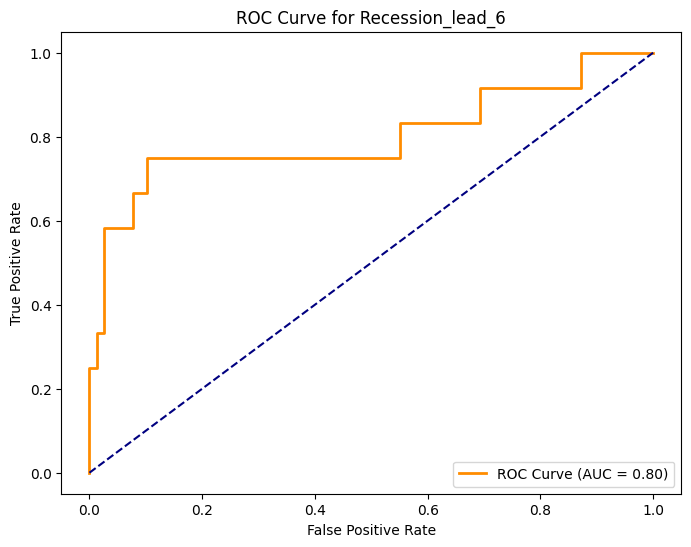

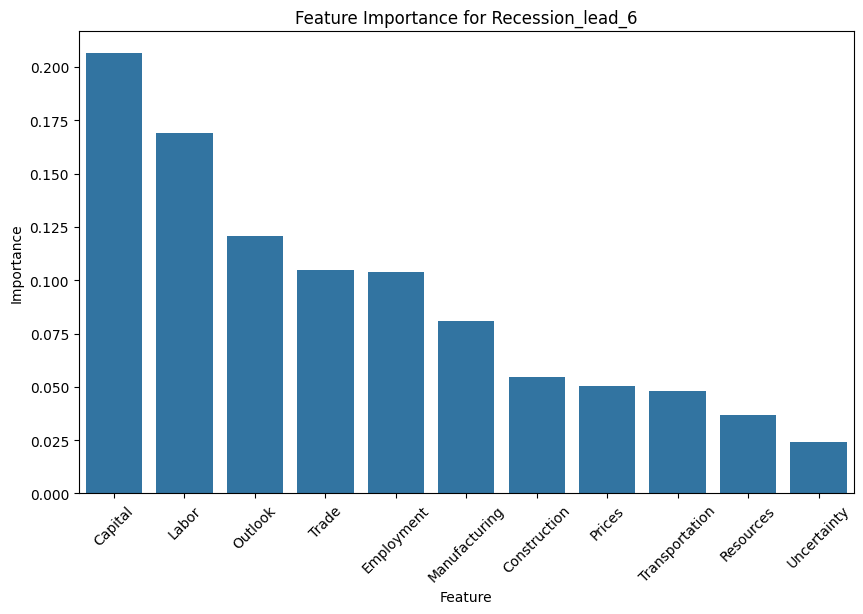


Random Forest Classification Report for Recession_lead_8:
              precision    recall  f1-score   support

         0.0       0.95      0.92      0.94        78
         1.0       0.57      0.67      0.62        12

    accuracy                           0.89        90
   macro avg       0.76      0.79      0.78        90
weighted avg       0.90      0.89      0.89        90



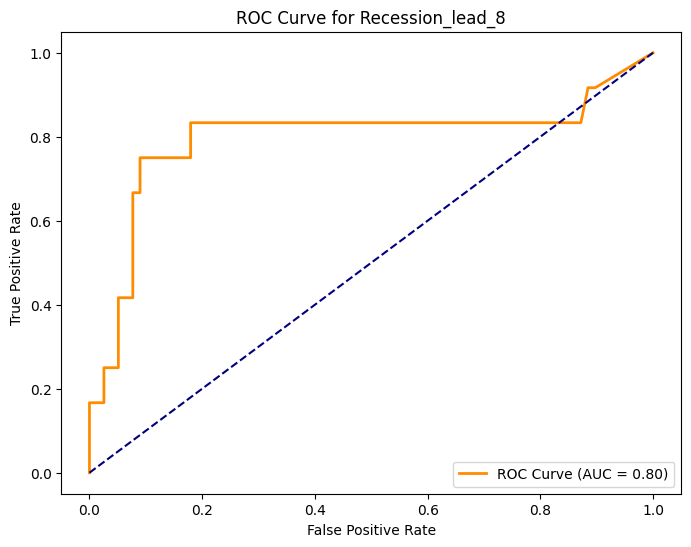

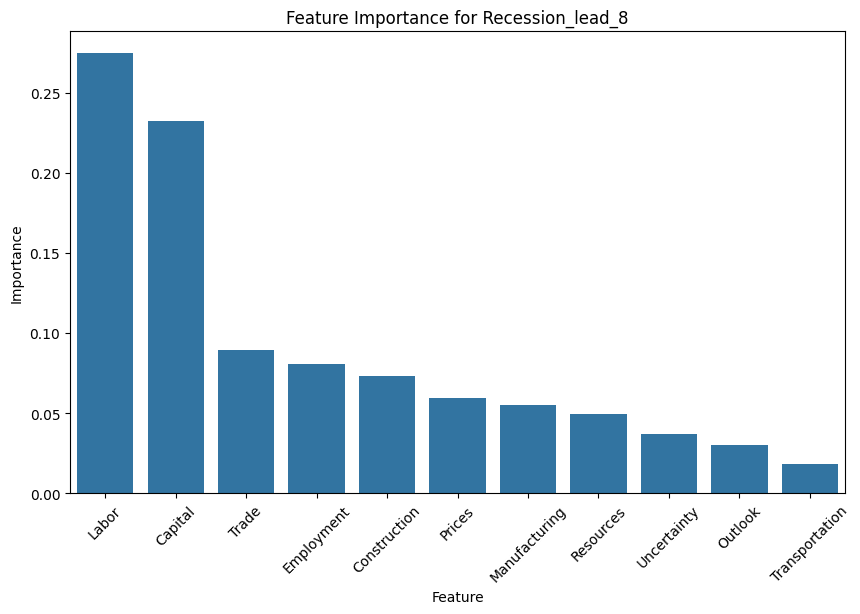


Random Forest Classification Report for Recession_lead_16:
              precision    recall  f1-score   support

         0.0       0.89      0.92      0.90        77
         1.0       0.40      0.31      0.35        13

    accuracy                           0.83        90
   macro avg       0.64      0.61      0.63        90
weighted avg       0.82      0.83      0.82        90



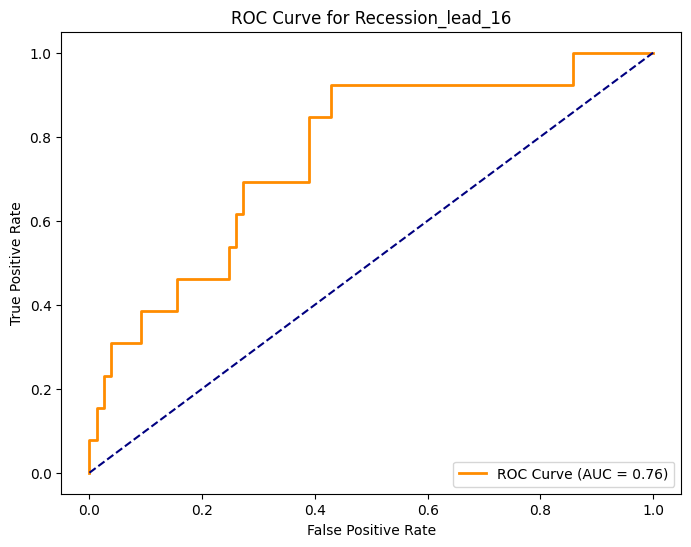

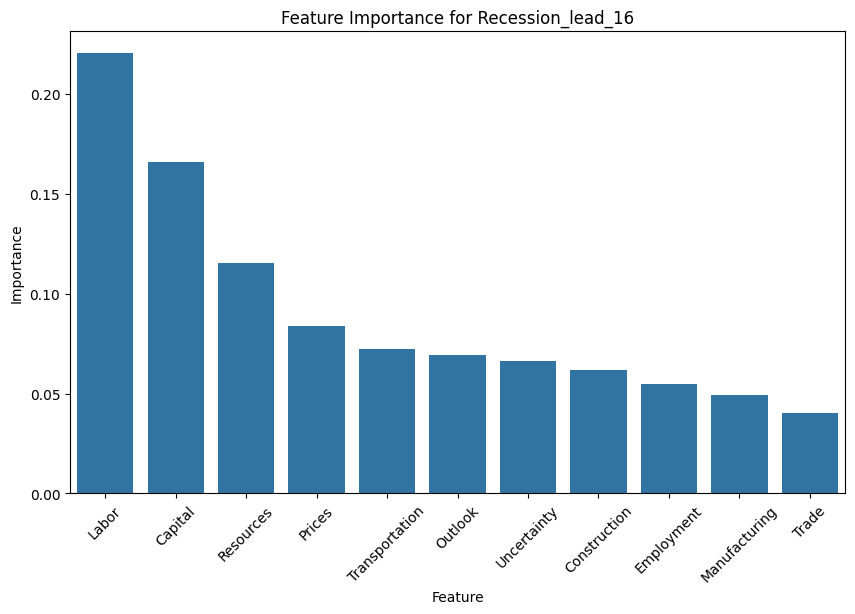


Random Forest Classification Report for Recession_lag_3:
              precision    recall  f1-score   support

         0.0       0.91      0.78      0.84        78
         1.0       0.26      0.50      0.34        12

    accuracy                           0.74        90
   macro avg       0.59      0.64      0.59        90
weighted avg       0.82      0.74      0.77        90



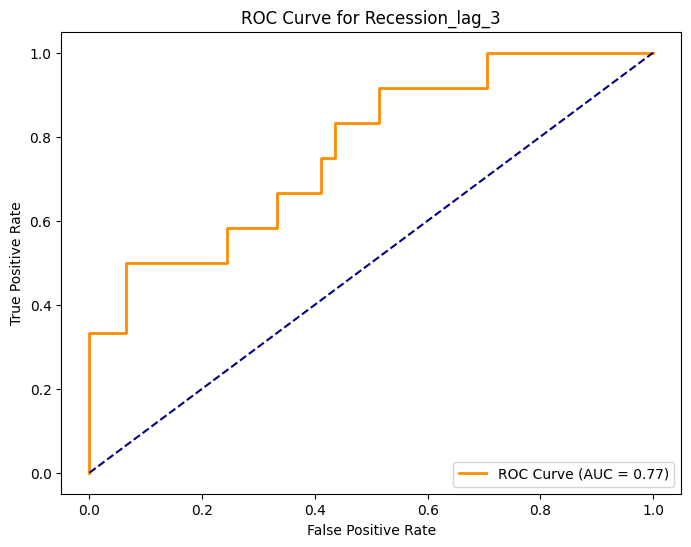

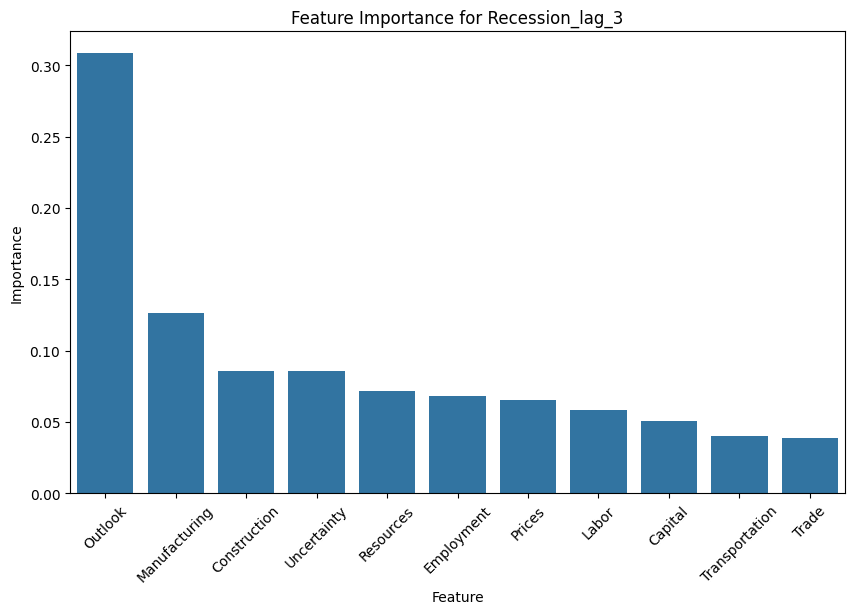


Random Forest Classification Report for Recession_lag_6:
              precision    recall  f1-score   support

         0.0       0.89      0.92      0.91        78
         1.0       0.33      0.25      0.29        12

    accuracy                           0.83        90
   macro avg       0.61      0.59      0.60        90
weighted avg       0.81      0.83      0.82        90



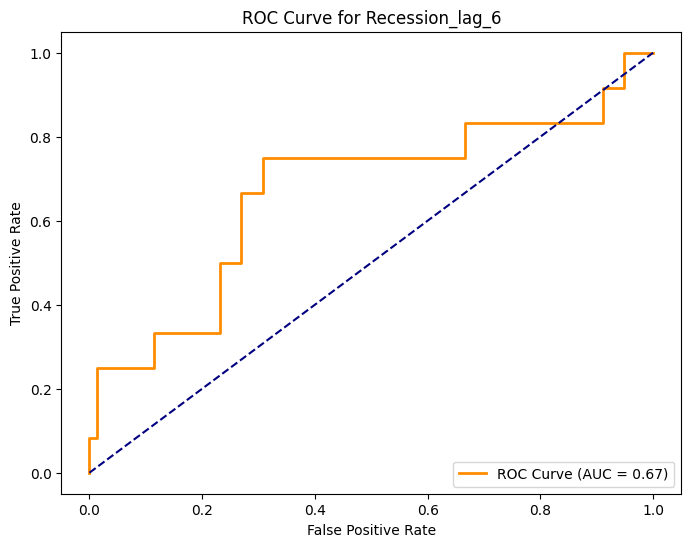

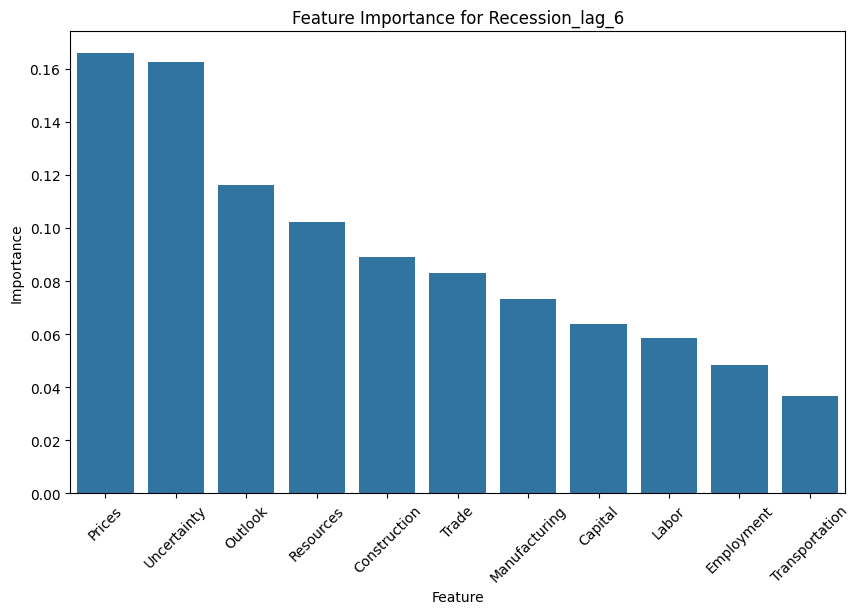

In [2]:
# Function to train Random Forest model for different targets
def train_rf(target_col):
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, df[target_col], test_size=0.2, random_state=42, stratify=df[target_col])

    # Train Random Forest Classifier
    rf = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=5, class_weight="balanced")
    rf.fit(X_train, y_train)

    # Predictions
    y_pred = rf.predict(X_test)
    y_pred_prob = rf.predict_proba(X_test)[:, 1]

    # Classification report
    print(f"\nRandom Forest Classification Report for {target_col}:")
    print(classification_report(y_test, y_pred))

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    roc_auc = roc_auc_score(y_test, y_pred_prob)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve for {target_col}")
    plt.legend(loc="lower right")
    plt.show()

    # Feature Importance
    importances = rf.feature_importances_
    sorted_indices = np.argsort(importances)[::-1]

    plt.figure(figsize=(10, 6))
    sns.barplot(x=np.array(topic_columns)[sorted_indices], y=importances[sorted_indices])
    plt.xticks(rotation=45)
    plt.xlabel("Feature")
    plt.ylabel("Importance")
    plt.title(f"Feature Importance for {target_col}")
    plt.show()

    return rf

# Train models for all leads and lags
models = {}
for target in ["Recession", "Recession_lead_3", "Recession_lead_6", "Recession_lead_8", "Recession_lead_16", "Recession_lag_3", "Recession_lag_6"]:
    models[target] = train_rf(target)


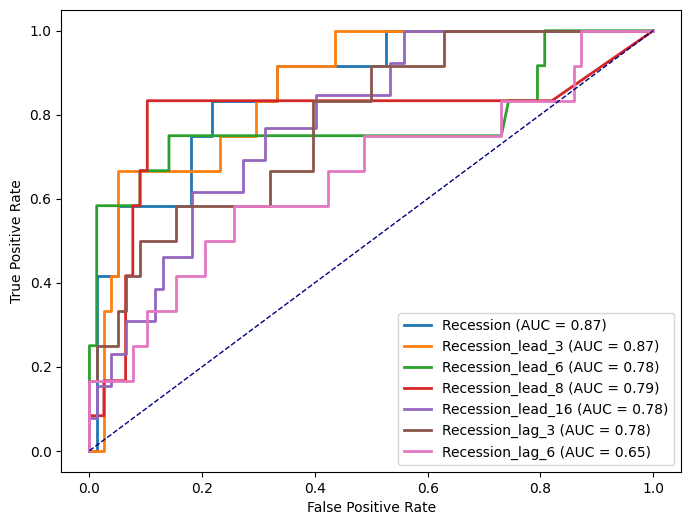

In [12]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split

# Standardize features again if needed
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[topic_columns])

# Plot all ROC curves on one graph
plt.figure(figsize=(8, 6))

for target, model in optimized_models.items():
    # Recreate train-test split dynamically for the given target
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, df[target], test_size=0.2, random_state=42, stratify=df[target]
    )

    # Predict probabilities
    y_pred_prob = model.predict_proba(X_test)[:, 1]
    
    # Compute ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    roc_auc = roc_auc_score(y_test, y_pred_prob)

    # Plot ROC curve
    plt.plot(fpr, tpr, lw=2, label=f'{target} (AUC = {roc_auc:.2f})')

# Reference diagonal line
plt.plot([0, 1], [0, 1], color='navy', linestyle='--', lw=1)

# Labels and title
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
#plt.title("ROC Curves for Different Lead/Lag Recession Predictions")
plt.legend(loc="lower right")
# Save as PNG file
plt.savefig("roc_curves_rf_essay3.png", dpi=300)
plt.show()
